### Basic ISC



#### Import modules

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, nilearn, pickle, glob,shutil
from nilearn import plotting, maskers, datasets
import numpy as np
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nilearn.plotting import view_img_on_surf, view_img
from nltools.stats import isc, threshold, fdr
from tqdm import tqdm

import pandas as pd
from statsmodels.stats.multitest import multipletests
from utils import *
import warnings
warnings.simplefilter("ignore")

#### Setup variables and filenames

In [2]:
n_iter                 = 5000
alpha                  = 0.05
twin_data_file         = '../data/00_dataset_info/twin_df.csv'
fmri_data_file         = '../data/03_extract_ts_aus/ts_array_shen268_pauli16_aan9.npy'
all293_rois_file       = '../data/02_rois_masks_maps/allcombined.nii'
masker_prefitting_file = '../data/02_rois_masks_maps/func.nii.gz'

#### Load viewer info, load timeseries

In [3]:
# load subject info
twin_df = pd.read_csv(twin_data_file)
sub_list = list(np.hstack((twin_df['twin_A_id'].values, twin_df['twin_B_id'].values)))
print("Number of subjects: " + str(len(sub_list)))

# load timeseries, swap axes
ts_array = np.load(fmri_data_file)
ts_data = np.swapaxes(ts_array, 0, 2)
ts_data = np.swapaxes(ts_data, 0, 1)
print("Shape of time series structure: " + str(ts_data.shape))

Number of subjects: 200
Shape of time series structure: (380, 293, 200)


#### Basic ISC analysis 
(via resampling stats)

100%|█████████████████████████████████████████| 293/293 [02:27<00:00,  1.99it/s]


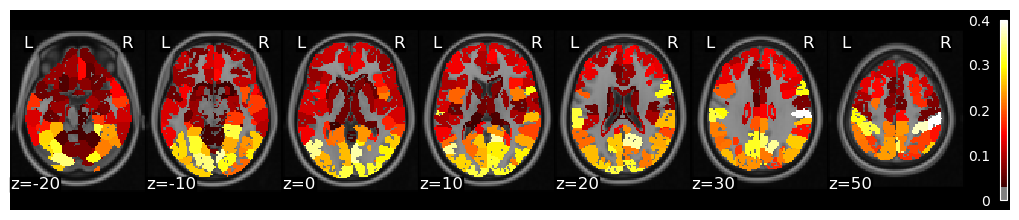

In [4]:
# set up mask
mask = Brain_Data(all293_rois_file)
mask_x = expand_mask(mask)
    
# run isc permutation/bootstrap analysis
p_results = []
isc_results = []
for curr_roi in tqdm(range(293)):
        #print(curr_roi)
        data_roi_df = pd.DataFrame(ts_data[:,curr_roi,:], columns = list(np.hstack((twin_df.twin_A_id.values, twin_df.twin_B_id.values)).flatten()) )
        stats_boot = isc(data_roi_df, method='bootstrap', n_samples=n_iter, return_null=True)
        #print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")
        p_results.append(stats_boot['p'])
        isc_results.append(stats_boot['isc'])


# map isc results back to brain
isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_results), mask_x), roi_to_brain(pd.Series(p_results), mask_x)
result_image = threshold(isc_r_brain, isc_p_brain, thr=fdr(inp.asarray(p_results), q = alpha)).to_nifti()

# visualize results
fig = plt.figure(figsize=(10, 2))
nilearn.plotting.plot_stat_map(    result_image, 
                                   bg_img       = '../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   threshold    = 0.03,  #additional threshold for visualization
                                   vmax         = 0.4, 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20, 30, 50],
                                   annotate     = True,
                                   figure = fig);


#### Additionally, take a far more conservative approach

100%|█████████████████████████████████████████| 293/293 [05:02<00:00,  1.03s/it]


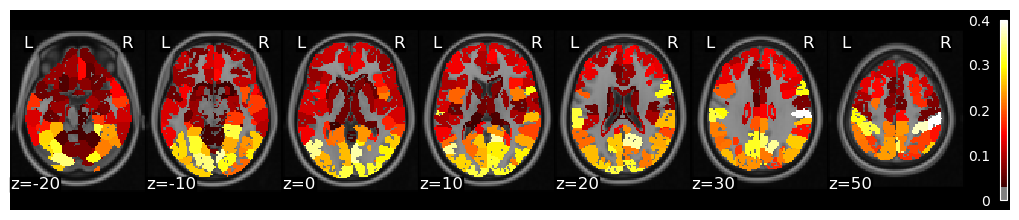

In [5]:
# run isc permutation/bootstrap analysis
p_results = []
isc_results = []
for curr_roi in tqdm(range(293)):
        #print(curr_roi)
        data_roi_df = pd.DataFrame(ts_data[:,curr_roi,:], columns = list(np.hstack((twin_df.twin_A_id.values, twin_df.twin_B_id.values)).flatten()) )
        stats_boot = isc(data_roi_df, method='bootstrap', n_samples= 10000, return_null=True)
        #print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")
        p_results.append(stats_boot['p'])
        isc_results.append(stats_boot['isc'])


# map isc results back to brain
isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_results), mask_x), roi_to_brain(pd.Series(p_results), mask_x)
result_image = threshold(isc_r_brain, isc_p_brain, thr=fdr(np.asarray(p_results), q = 0.005)).to_nifti()

# visualize results
fig = plt.figure(figsize=(10, 2))
nilearn.plotting.plot_stat_map(    result_image, 
                                   bg_img       = '../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   threshold    = 0.03,  #additional threshold for visualization
                                   vmax         = 0.4, 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20, 30, 50],
                                   annotate     = True,
                                   figure = fig);


#### Additional explorations of variants of computing and testing ISC

In [6]:
curr_roi    = 47
data_roi_df = pd.DataFrame(ts_data[:,curr_roi,:], columns = list(np.hstack((twin_df.twin_A_id.values, twin_df.twin_B_id.values)).flatten()) )

stats_circle = isc(data_roi_df, method='circle_shift', n_samples=5000, return_null=True)
print(f"ISC: {stats_circle['isc']:.02}, p = {stats_circle['p']:.03}")

stats_phase = isc(data_roi_df, method='phase_randomize', n_samples=5000, return_null=True)
print(f"ISC: {stats_phase['isc']:.02}, p = {stats_phase['p']:.03}")

stats_boot = isc(data_roi_df, method='bootstrap', n_samples=5000, return_null=True)
print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

ISC: 0.27, p = 0.0002
ISC: 0.27, p = 0.0002
ISC: 0.27, p = 0.0002


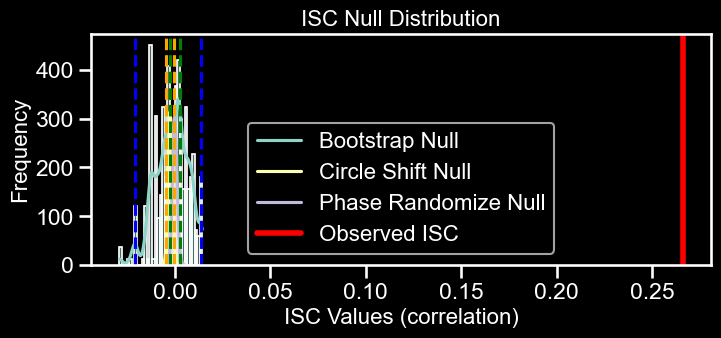

In [7]:
fs = 16

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

plt.figure(figsize=(8,3));
sns.histplot(stats_boot['null_distribution'] - stats_boot['isc'], kde=True, label='Bootstrap');
sns.histplot(stats_circle['null_distribution'], kde=True, label='Bootstrap');
sns.histplot(stats_phase['null_distribution'], kde=True, label='Bootstrap');
plt.ylabel('Frequency', fontsize= fs);
plt.xlabel('ISC Values (correlation)', fontsize= fs);
plt.title('ISC Null Distribution', fontsize= fs);
plt.axvline(stats_boot['isc'], linestyle='-', color='red', linewidth=4);
plt.legend(['Bootstrap Null','Circle Shift Null', 'Phase Randomize Null', 'Observed ISC'], fontsize=fs);
    
plt.axvline(stats_boot['ci'][0] - stats_boot['isc'], linestyle='--', color='blue');
plt.axvline(stats_boot['ci'][1] - stats_boot['isc'], linestyle='--', color='blue');
    
plt.axvline(stats_circle['ci'][0], linestyle='--', color='orange');
plt.axvline(stats_circle['ci'][1], linestyle='--', color='orange');
    
plt.axvline(stats_phase['ci'][0], linestyle='--', color='green');
plt.axvline(stats_phase['ci'][1], linestyle='--', color='green');
plt.show()

0
ISC: 0.062, p = 0.0002


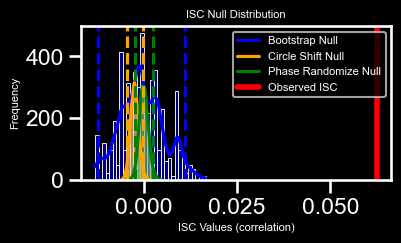

1
ISC: 0.075, p = 0.0002


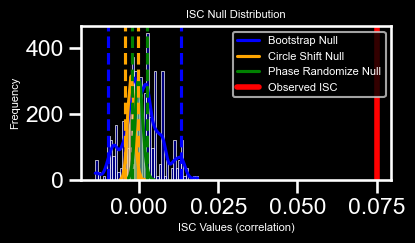

2
ISC: 0.15, p = 0.0002


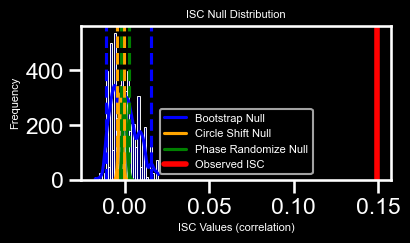

3
ISC: 0.048, p = 0.0002


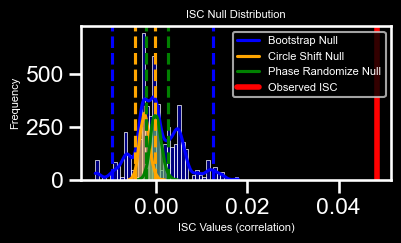

4
ISC: 0.14, p = 0.0002


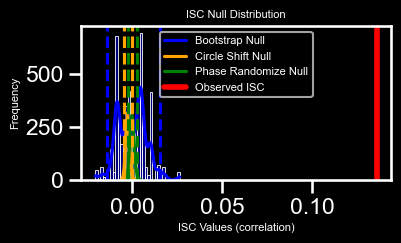

In [8]:
# generalizing this to many  regions

p_results = []
isc_results = []

for curr_roi in range(5): #removed from 293 to only 5 to make notebook smaller
    print(curr_roi)
    data_roi_df = pd.DataFrame(ts_data[:,curr_roi,:], columns = list(np.hstack((twin_df.twin_A_id.values, twin_df.twin_B_id.values)).flatten()) )
    stats_boot = isc(data_roi_df, method='bootstrap', n_samples=5000, return_null=True)
    print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")
    p_results.append(stats_boot['p'])
    isc_results.append(stats_boot['isc'])

    fs = 8
    plt.figure(figsize=(4,2));
    sns.histplot(stats_boot['null_distribution'] - stats_boot['isc'], kde=True, label='Bootstrap', color = 'blue');
    sns.histplot(stats_circle['null_distribution'], kde=True, label='Bootstrap', color = 'orange');
    sns.histplot(stats_phase['null_distribution'], kde=True, label='Bootstrap', color = 'green');
    plt.ylabel('Frequency', fontsize= fs);
    plt.xlabel('ISC Values (correlation)', fontsize= fs);
    plt.title('ISC Null Distribution', fontsize= fs);
    plt.axvline(stats_boot['isc'], linestyle='-', color='red', linewidth=4);
    plt.legend(['Bootstrap Null','Circle Shift Null', 'Phase Randomize Null', 'Observed ISC'], fontsize=fs);
    
    plt.axvline(stats_boot['ci'][0] - stats_boot['isc'], linestyle='--', color='blue');
    plt.axvline(stats_boot['ci'][1] - stats_boot['isc'], linestyle='--', color='blue');
    
    plt.axvline(stats_circle['ci'][0], linestyle='--', color='orange');
    plt.axvline(stats_circle['ci'][1], linestyle='--', color='orange');
    
    plt.axvline(stats_phase['ci'][0], linestyle='--', color='green');
    plt.axvline(stats_phase['ci'][1], linestyle='--', color='green');
    plt.show()

#### Alternative visualization

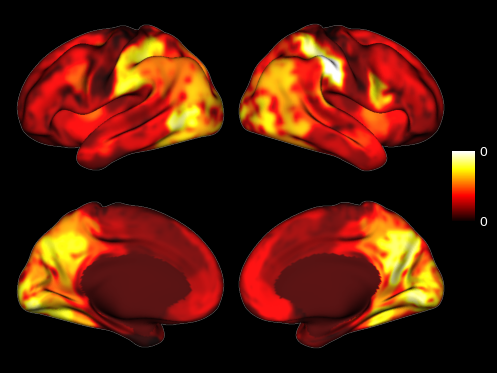

In [9]:
from surfplot import Plot
from neuromaps.datasets import fetch_fslr
from neuromaps.transforms import mni152_to_fslr
import panel as pn
pn.extension('vtk')

#import os
#os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
#os.environ['DISPLAY'] = ':99'

# Fetch fsLR surfaces from neuromaps
surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
sulc_lh, sulc_rh = surfaces['sulc']

# Convert volumetric MNI data to fsLR surface
gii_lh, gii_rh = mni152_to_fslr(nilearn.image.smooth_img(result_image, 4), method='linear')

# Plot example ROI on surface
p = Plot(surf_lh=lh, surf_rh=rh, brightness=.7)
p.add_layer({'left': gii_lh, 'right': gii_rh}, cmap='hot', color_range=(0, 0.4))
cbar_kws = dict(location='right', draw_border=False, aspect=3,
                shrink=.2, decimals=0, pad=0, n_ticks=2)
fig = p.build(cbar_kws=cbar_kws)